In [63]:
import numpy as np
from utils import get_images, plot_number

mnist_path = './data/mnist_raw/'
x_train_num,y_train_num,x_test_num,y_test_num = get_images(mnist_path)

numero: 2


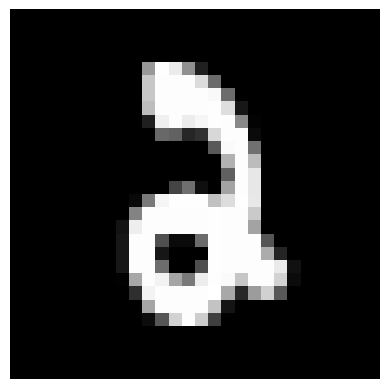

In [64]:
rand_idx = np.random.randint(len(y_test_num))
print(f'numero: {y_test_num[rand_idx]}')
plot_number(x_test_num[rand_idx])

In [66]:
# convertir imágenes en vectores y float32

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float64)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float64)/255
y_test = y_test_num.copy().reshape(10000, 1)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

In [69]:
print(f'{x_train.shape[1]} parámetros')

784 parámetros


La imagen la convertimos a un vector de 784 elementos. 
crearemos dos capas de 200 neuronas y 10 neuronas.
La pasamos por una función de activación, usaremos la ReLU.

No podemos procesar los 50000 datos de golpe, por que usariamos demasiado uso de memoria. Vamos a dividir nuestros datos de entrada en una matriz.

In [70]:
#creamos una función minibach, y el paso de elementos serían
# en potencias de 2
# por ejemplo de los 50000 datos pasamos de 16 en 16 o 32 en 32
# o de 128 en 128, ....

def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

Vamos a definir nuestros parametros y funciones para el forward pass, función de activación ReLU, función de activación
softmax y luego la función de pérdida.

In [71]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> elementos de entrada, 784
    neurons -> list [200, 10] con cantidad de neuronas en cada capa
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [72]:
parameters = init_parameters(28*28,[200,10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b1'].shape)
print(parameters['b2'].shape)

(200, 784)
(10, 200)
(200, 1)
(10, 1)


### Función ReLU
$$a^1 = ReLU(z^1) $$

In [73]:
def relu(x):
    return np.maximum(0, x)

### Salida Lineal
$$z^1 = W^1 X + b^1$$

In [74]:
def scores(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

### Función de activación softmax
$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$

In [75]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

### Función de pérdida
$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$

In [76]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

### Función de retropropagación

In [77]:
def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads

### Ciclo de entrenamiento (iteración o epoch)

In [78]:
# función de medición
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = scores(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [79]:
# función de entrenamiento
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = scores(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters

In [80]:
#entrenando
mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters = train(epochs=epochs,parameters=parameters,mb_size=mb_size,learning_rate=learning_rate)

costo es: 0.5359699711817183, y accuracy: 0.8699
costo es: 0.38085216794966315, y accuracy: 0.9004
costo es: 0.3162411836937759, y accuracy: 0.9131
costo es: 0.2371542373375306, y accuracy: 0.924
costo es: 0.3047589609516316, y accuracy: 0.928
costo es: 0.20715449130320665, y accuracy: 0.9356
costo es: 0.20251192797273784, y accuracy: 0.9405
costo es: 0.19661987380340645, y accuracy: 0.9448
costo es: 0.2621265116478647, y accuracy: 0.9493
costo es: 0.20270553069561037, y accuracy: 0.9501
costo es: 0.18602693852217966, y accuracy: 0.9538
costo es: 0.1293126914694771, y accuracy: 0.9557
costo es: 0.15585263588073012, y accuracy: 0.9582
costo es: 0.16231552637295255, y accuracy: 0.959
costo es: 0.16675123707719844, y accuracy: 0.9616
costo es: 0.12650486825699211, y accuracy: 0.9627
costo es: 0.11450738265249379, y accuracy: 0.9639
costo es: 0.13160663569940748, y accuracy: 0.9651
costo es: 0.06087557368217108, y accuracy: 0.966
costo es: 0.09012532437429314, y accuracy: 0.9671


### predicción

In [81]:
def predict(x):
    scores2, _, _ = scores(x, parameters, relu)
    return np.argmax(scores2)

el valor predicho es: 1


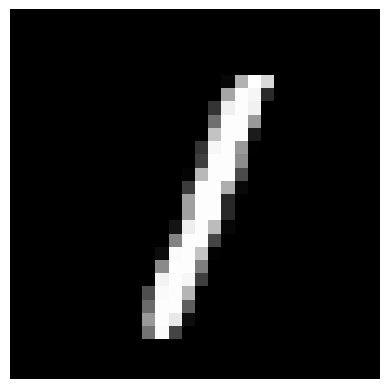

In [85]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')